# BMDC 1D Analysis

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import itertools
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline

In [2]:
pd.set_option('max_columns', None)

In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [4]:
data_path = '/data_volume/memento/bmdc/'

### Read the guide labled K562 data

From perturbseq paper

In [5]:
adata = sc.read(data_path + 'h5ad/filtered-bmdc.h5ad')

In [6]:
guides = []
for s in adata.obs.guide_string:
    guides += s.split('-')
guides = list(set(guides))

In [7]:
# guides = adata.obs.guides.drop_duplicates().tolist()
# guides = [g for g in guides if ('INTER' not in g and 'nan' not in g)]
# ko_genes = adata.obs.query('KO == 1')['KO_GENE'].drop_duplicates().tolist()

### Setup memento

In [8]:
adata.obs['q'] = 0.07

In [9]:
memento.setup_memento(adata, q_column='q', filter_mean_thresh=0.07)

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:68: RankWarning: Polyfit may be poorly conditioned


### Memento

In [11]:
subset

AnnData object with n_obs × n_vars = 1348 × 3315
    obs: 'guide', 'guide_string', 'tp', 'batch', 'WT', 'KO', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'q', 'memento_size_factor', 'memento_group'
    var: 'gene_id-0', 'gene_id-1'
    uns: 'memento'

In [13]:
for g in guides:
    
    subset = adata[
        (adata.obs.WT | adata.obs.guide_string.str.contains(g)) & adata.obs.leiden.isin(['0', '1'])
    ].copy().copy()
    
    memento.create_groups(subset, label_columns=['KO', 'leiden'])
    memento.compute_1d_moments(subset, min_perc_group=.9)
    
    memento.ht_1d_moments(
        subset, 
        formula_like='1 + KO + leiden + KO:leiden',
        cov_column='KO:leiden', 
        num_boot=10000, 
        verbose=1,
        num_cpus=70)
    
    break
    
#     subset.write(data_path + '2d_self_h5ad/{}.h5ad'.format(g))

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


UnboundLocalError: local variable 'cov_idx' referenced before assignment

In [35]:
df = memento.get_1d_ht_result(subset)

In [36]:
df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])
df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])

(array([392., 571., 573., 550., 466., 475., 428., 389., 392., 387.]),
 array([0.00124351, 0.10105917, 0.20087482, 0.30069048, 0.40050613,
        0.50032179, 0.60013744, 0.6999531 , 0.79976875, 0.89958441,
        0.99940006]),
 <BarContainer object of 10 artists>)

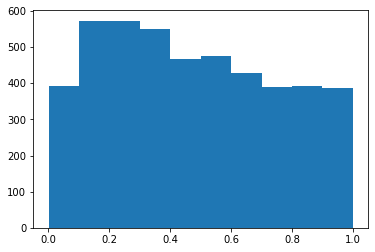

In [38]:
plt.hist(df['dv_pval'])